# Modeling: Bernoulli Naive Bayes
---
#### Import libraries and read data


In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Binarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import BernoulliNB
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [144]:
df = pd.read_csv('../data/explored_skincare.csv')

df.head(2)

,author,title,selftext,num_comments,score,subreddit,is_ab,title_word_count,title_char_count,selftext_word_count,selftext_char_count,combined_text
0,lululi_lululi,After working with seasoned estheticians throu...,Through our own project ([Glowism] my friend a...,4,1,asianbeauty,1,24,164,611,3798,After working with seasoned estheticians throu...
1,BasicBake,How often do you wash your face with just water?,"Hello,\n\nI was wondering how often you wash y...",8,2,asianbeauty,1,9,48,109,568,How often do you wash your face with just wate...


## Assign $X$ and $y$ variables
---
In this model, I am only interested in seeing if a mention of word pair in a post can predict the outcome. Thus I am only including the text feature.

In [149]:
features = ['combined_text']

In [150]:
X = df[features]
y = df['is_ab']

## Train-test-split data
---

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42,
                                                   stratify = y)

## Set and fit model
---
**The Model**

This Bernoulli Naive Bayes model utilizes the following parameters:
- `ngram_range` of word pairs (2,2),
- custom stopwords, and
- `cv` of 5 folds.


##### Step 1: Define functions to grab each features separately

In [152]:
category = FunctionTransformer(lambda x: x['combined_text'], validate = False)

# Riley Dallas and Daniel Kim

##### Step 2: Set a pipeline with transformers and an estimator

In [153]:
pipe = Pipeline([
    ('selector', category),
    ('cvec', CountVectorizer()),
    ('bnr', Binarizer()),
    ('bnb', BernoulliNB())
])

# Daniel Kim

##### Step 3: Set parameters for gridsearch

In [ ]:
custom_stopwords = pickle.load(open('../assets/custom_stopwords.pkl', 'rb'))

In [154]:
params = {'cvec__stop_words' : [custom_stopwords],
          'cvec__ngram_range' : [(2,2)]}

##### Step 4: Instantiate and fit gridsearch

In [155]:
gs = GridSearchCV(pipe, params, cv=5)

gs.fit(X_train, y_train);

## Evaluate model
---
### Accuracy scores
The model is highly overfit, as shown in the high accuracy score on training data, but low in unseen data. Compared to the baseline and the other two models' scores, this model is performing rather bad at predicting outcomes.

Because of the mentioned concerns, this model is not a good option to use in production.

In [156]:
print(f'Train Score: {gs.score(X_train, y_train)}')
print(f'Train Score: {gs.score(X_test, y_test)}')

Train Score: 0.9079970104633782
Train Score: 0.65635507733692


### Check coefficient weights

Looking at the top 20 coefficient weights, the most contributive features are more or less the same as the 2nd Logistic Regression iteration.

However, the interpretation differs. Taking the most contributing feature, 'sheet masks,' with a weight of 0.05. A mention of sheet masks in a post increases the odds of a post coming from the AsianBeauty subreddit by 0.05 times.

In [157]:
coefficients = gs.best_estimator_.named_steps['bnb'].coef_[0]

feature_names = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef_df = pd.DataFrame({
    'features': feature_names,
    'coef' : coefficients,
    'exp_coef': [np.exp(coef) for coef in coefficients]
             })

# Daniel Kim

In [158]:
#pd.set_option('display.max_rows', 100)
round(coef_df.sort_values('exp_coef', ascending=False),2).head(20)

# Daniel Kim

,features,coef,exp_coef
397346,sheet masks,-2.92,0.05
406967,skin type,-3.08,0.05
397341,sheet mask,-3.12,0.04
131884,don know,-3.14,0.04
195465,hada labo,-3.16,0.04
135866,dry skin,-3.17,0.04
16361,acne prone,-3.25,0.04
147056,etude house,-3.27,0.04
29079,amp x200b,-3.36,0.03
391979,sensitive skin,-3.40,0.03


### Plot top 20 word pairs

In [162]:
top_20_words = coef_df.loc[4:][['features','exp_coef']].sort_values('exp_coef', ascending=True).tail(20)

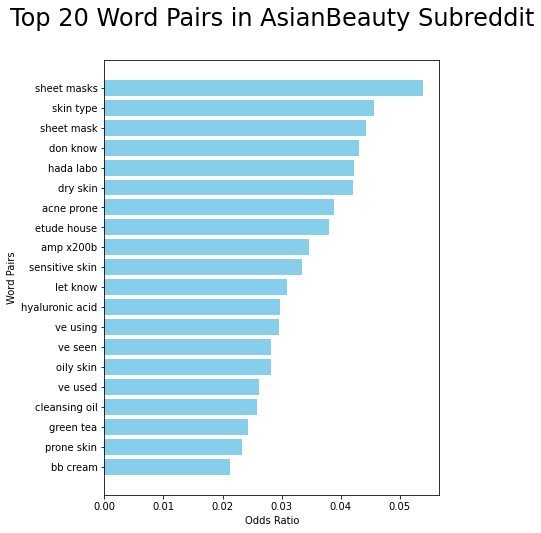

In [160]:
plt.figure(figsize=(6,8))
plt.barh(top_20_words['features'].values,
         top_20_words['exp_coef'].values,
        color='skyblue')

plt.title('Top 20 Word Pairs in AsianBeauty Subreddit\n', fontsize=24)
plt.xlabel('Odds Ratio')
plt.ylabel('Word Pairs');